In [168]:
import mujoco_py

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
from tqdm import tqdm
import random

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
train_env = gym.make('Humanoid-v2')
test_env = gym.make('Humanoid-v2')

SEED = 333

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
random.seed(SEED)
torch.manual_seed(SEED);

/home/gswatiseas/gym/gym/envs/registration.py:579: UserWarning: WARN: The environment Humanoid-v2 is out of date. You should consider upgrading to version v3 with the environment ID `Humanoid-v3`.
  f"The environment {spec.id} is out of date. You should consider "


Run: 0: 100%|███████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.85it/s]


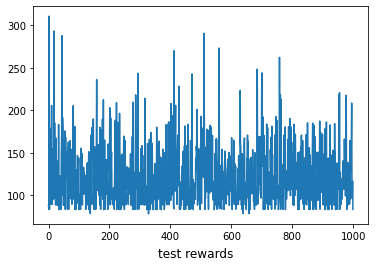

In [244]:
#Baseline (just take random actions)
n_runs = 1
n_episodes = 1000
test_rewards = np.zeros((n_runs, n_episodes))

for run in range(n_runs):
    for episode in tqdm(range(n_episodes), desc=f'Run: {run}'):
        done = False
        episode_reward = 0
        test_env.reset()
        while not done:
            action = test_env.action_space.sample() # your agent here (this takes random actions)
            observation, reward, done, info = test_env.step(action)
            episode_reward+=reward
            #print (reward, episode_reward, done)
        test_rewards[run][episode] = episode_reward
#     plt.figure()
#     plt.plot(train_rewards[run])
#     plt.figtext(0.5, 0.01, "train rewards", wrap=True, horizontalalignment='center', fontsize=12)
#     plt.show()         
    plt.figure()
    plt.plot(test_rewards[run])
    plt.figtext(0.5, 0.01, "test rewards", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

In [4]:
discrete_action_space_dim = 9
input_dim = train_env.observation_space.shape[0]
hidden_dim = 765
output_dim = train_env.action_space.shape[0] * discrete_action_space_dim
device = torch.device('cuda')
#output_dim = train_env.action_space.shape[0]
print (input_dim, output_dim)

376 153


In [5]:
action = train_env.action_space.sample()
#print (action.type)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

In [7]:
policy = MLP(input_dim, hidden_dim, output_dim)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
        
def get_actions(action_indices):
    actions = [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
    ret_actions = np.zeros(train_env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = actions[index]
    return ret_actions
        

In [9]:
policy.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=153, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool1d(kernel_size=9, stride=9, padding=0, dilation=1, ceil_mode=False)
)

In [10]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [11]:
def train(env, policy, optimizer, discount_factor, epsilon, device):
    
    policy.train()
    
    states = []
    actions = []
    rewards = []
    next_states = []
    done = False
    episode_reward = 0

    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)

    while not done:
        #print ("state: ", state.shape)
        if np.random.random() < epsilon:
            action = env.action_space.sample()
            #print ("action 1:", action.shape)
        else:
            q_pred, action_indices = policy(state)
            action = get_actions(action_indices.view((-1)))
            #print ("action 2:", action.shape)

        next_state, reward, done, _ = env.step(action)
        #print ("next_state: ", next_state.shape)

        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)

        episode_reward += reward

        loss = update_policy(policy, state, action, reward, next_state, discount_factor, optimizer)
        state = next_state

    return loss, episode_reward, epsilon

In [12]:
def update_policy(policy, state, action, reward, next_state, discount_factor, optimizer):
    #print ("state: ", state.shape)
    q_vals, action_indices = policy(state)
    #print ("q_vals: ", q_vals.shape, "action indices: ", action_indices.shape)
    action_preds = get_actions(action_indices.view((-1)))

    with torch.no_grad():
        q_next_vals, action_next_indices = policy(next_state)
        action_next_preds = get_actions(action_indices.view((-1)))
        targets = reward + q_next_vals.sum() * discount_factor

    loss = F.smooth_l1_loss(targets.detach(), q_vals)
    
    optimizer.zero_grad()
    
    loss.backward()

    nn.utils.clip_grad_norm_(policy.parameters(), 0.5)

    optimizer.step()
    
    return loss.item()

In [13]:
def evaluate(env, policy, device):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q, action_indices = policy(state)
            action = get_actions(action_indices.view((-1)))

        state, reward, done, _ = env.step(action)

        episode_reward += reward

    return episode_reward

In [14]:
# Define the nET
policy = MLP(input_dim, hidden_dim, output_dim)
policy = policy.to(device)
policy.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=153, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool1d(kernel_size=9, stride=9, padding=0, dilation=1, ceil_mode=False)
)

Run: 0: 100%|█████████████████████████████████████████| 10000/10000 [19:42<00:00,  8.46it/s]


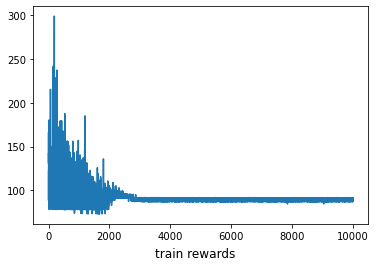

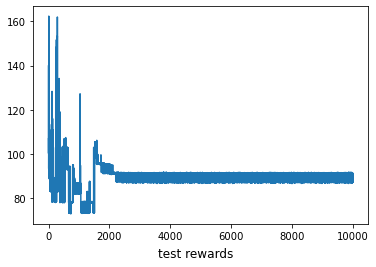

In [15]:
import warnings
warnings.filterwarnings('ignore')

n_runs = 1
n_episodes = 10000
discount_factor = 0.8
start_epsilon = 0.0
end_epsilon = 0.01
epsilon_decay = 0.99965
learnin_rate = 1e-6
#epsilon_decay = 0.99965

train_rewards = torch.zeros(n_runs, n_episodes)
test_rewards = torch.zeros(n_runs, n_episodes)

#device = torch.device('cpu')

for run in range(n_runs):
    
    epsilon = start_epsilon

    optimizer = optim.RMSprop(policy.parameters(), lr=learnin_rate)

    for episode in tqdm(range(n_episodes), desc=f'Run: {run}'):

        loss, train_reward, epsilon = train(train_env, policy, optimizer, discount_factor, epsilon, device)

        #epsilon *= epsilon_decay
        #epsilon = min(epsilon, end_epsilon)

        test_reward = evaluate(test_env, policy, device)
        
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward
    plt.figure()
    plt.plot(train_rewards[run])
    plt.figtext(0.5, 0.01, "train rewards", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()
                
    plt.figure()
    plt.plot(test_rewards[run])
    plt.figtext(0.5, 0.01, "test rewards", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()
    

In [ ]:
# import gym
# env = gym.make("Humanoid-v2")
# observation = env.reset()
# total_reward_so_far = 0
# curr_action = env.action_space.sample()
# curr_state = np.zeros((input_dim, 1))
# gamma = 0.9

# def Q(state, action):
#     # TODO
#     return 0

# def next_action(curr_state, curr_action):
#     qval = Q(curr_state, curr_action)
    
        
    

# for _ in range(1000):
#   #env.render()
#   curr_state, curr_reward, done, info = env.step(curr_action)
#   curr_action = next_action(curr_state, curr_action) # your agent here (this takes random actions)
#   target = curr_reward + gamma * np.max()
#   total_reward_so_far += curr_reward
#   print ("ob: ", observation)
#   print ("reward: ", reward)
#   print ("done ", done)
#   print ("info: ", info)
#   if done:
#     observation = env.reset()
# env.close()
# print (total_reward)

In [ ]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i], c='red')
    _ax.plot(idxs, test_rewards[i], c='blue')
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

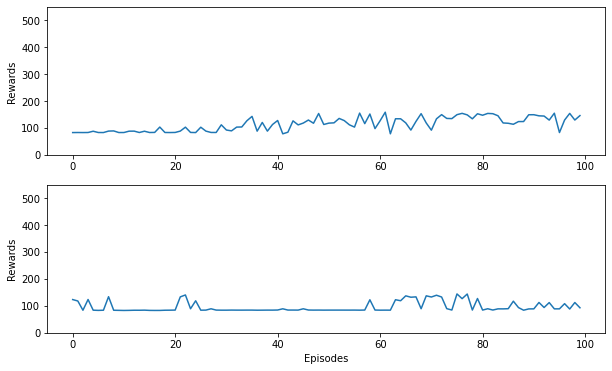

In [197]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, test_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

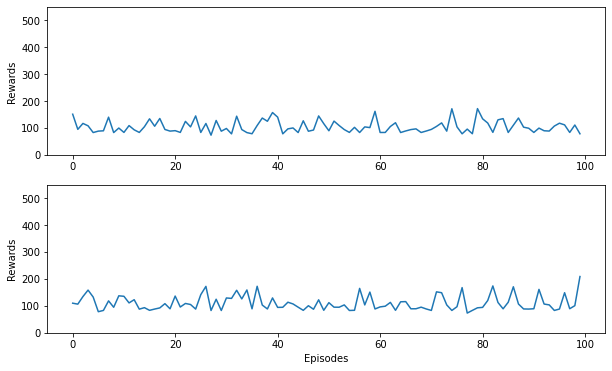

In [198]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

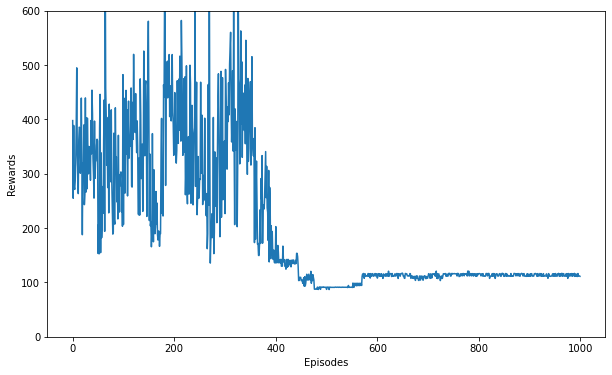

In [221]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.set_ylim(0, 600)
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

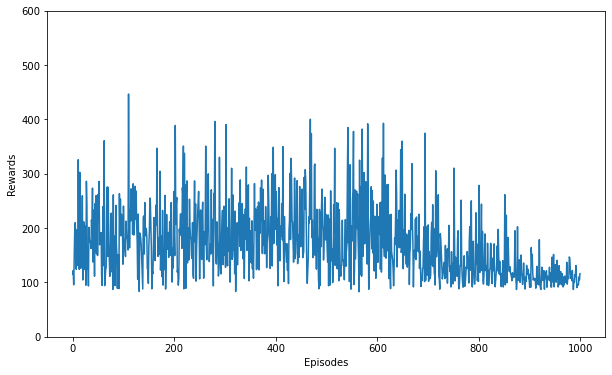

In [222]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, train_rewards.mean(0))
ax.set_ylim(0, 600)
ax.fill_between(idxs, train_rewards.min(0).values, train_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

0.99965


(0.0, 1.1)

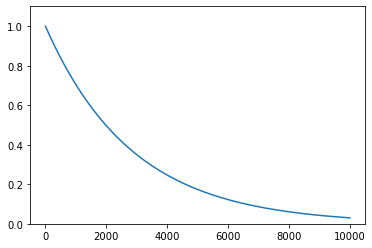

In [210]:
n = 10000
start_x = 1.0
decay = 0.99965
print(decay)
min_x = 0.01
x = start_x
ys = []
for i in range(n):
    x *= decay
    x = max(x, min_x)
    ys.append(x)
plt.plot(ys)
plt.ylim(0,1.1)

In [191]:
train_rewards[0, 1]

tensor(223.2789)

In [192]:
train_rewards[0, 4999]

IndexError: index 4999 is out of bounds for dimension 1 with size 100

In [ ]:
test_rewards[0, 1]

In [ ]:
test_rewards[0, 4999]

In [ ]:
plt.plot(test_rewards.flatten())

In [ ]:
PATH = '/home/gswatiseas/policy.pk1'
torch.save(policy.state_dict(), PATH)

In [ ]:
!pwd


In [ ]:
PATH = '/home/gswatiseas/policy_full.pk1'
torch.save(policy, PATH)

In [ ]:
%%javascript
IPython.notebook.save_notebook()